##### Setting up the Environment

In [2]:
from keras import Model
from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, Flatten, BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from tensorflow import as_dtype
from matplotlib import pyplot as plt
from model_profiler import model_profiler
from tqdm import tqdm
import numpy as np
import time

2023-02-08 21:48:41.858582: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


##### Evaluation Function

In [13]:
def evaluateModel(model, x_test, y_test, modelName):
	score = model.evaluate(x_test, y_test, verbose=1)

	pred = model.predict(x_test)
	x, y = [], []

	for sample in pred:
		x.append(sample.max() * 100)

	for confidence in x:
		y.append(((x > confidence).sum() / len(pred)) * 100)

	plt.plot(x, y, '.', color="black", markersize=1, label="Confidence of " + modelName + " Predictions")
	plt.ylim(max(y) + 1, min(y))
	plt.xlabel("Confidence (%)")
	plt.ylabel("Higher Confidence Predictions (%)")
	plt.legend()
	plt.show()

	return score[1]

##### Data Cleaning

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# this reshaping and input shape creation is convenient due to the three AlexNets requiring different inputs
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3).astype('float32') / 255
input_shape = (32, 32, 3)

units = ['GPU IDs', 'MFLOPs', 'MB', 'Million', 'MB']

##### Defining the 2-Layer MLP Network

In [11]:
MLP = Sequential()
MLP.add(Conv2D(10, kernel_size=(3,3), strides=(4, 4), input_shape=input_shape))
MLP.add(Flatten())
MLP.add(Dense(10, activation='softmax'))

#### Defining LeNet-5

In [7]:
LeNet5 = Sequential()

# 1st Convolutional Layer and Average Pooling
LeNet5.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
LeNet5.add(AveragePooling2D())

# 2nd ConvolutionalLayer and Average Pooling
LeNet5.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
LeNet5.add(AveragePooling2D())

# Fully-Connected Flatten()
LeNet5.add(Flatten())

# Three fully-connected layers
LeNet5.add(Dense(64, activation='relu'))
LeNet5.add(Dense(32, activation='relu'))
LeNet5.add(Dense(10, activation='softmax'))

#### Defining AlexNet

In [8]:
AlexNet = Sequential()

# 1st Convolutional Layer and Max Pooling
AlexNet.add(Conv2D(filters=32, input_shape=input_shape, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
AlexNet.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))

# 2nd Convolutional Layer and Max Pooling
AlexNet.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
AlexNet.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))

# 3rd Convolutional Layer
AlexNet.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))

# 4th Convolutional Layer
AlexNet.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))

# Max Pooling
AlexNet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

# Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(512, activation='relu'))

AlexNet.add(Dropout(0.3))

# Output Layer
AlexNet.add(Dense(10, activation='softmax'))

#### Compiling and Fitting the MLP

In [12]:
MLP.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
MLP.fit(x=x_train, y=y_train, epochs=10)

2023-02-08 21:52:44.301792: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.9673 - accuracy: 0.2959
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.7582 - accuracy: 0.3949
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.7112 - accuracy: 0.4156
Epoch 4/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.7067 - accuracy: 0.4153
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.6906 - accuracy: 0.4249
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.6940 - accuracy: 0.4233
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.6860 - accuracy: 0.4266
Epoch 8/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.6746 - accuracy: 0.4296
Epoch 9/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6785 - accuracy: 0.4285
Epoch 10/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.670

#### Evaluating the MLP

| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.0005  | MFLOPs  |
| GPU Memory Requirement           | 0.1639  | MB      |
| Model Parameters                 | 0.0067  | Million |
| Memory Required by Model Weights | 0.0255  | MB      |


2023-02-08 21:54:01.308390: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-08 21:54:01.308984: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-08 21:54:01.309054: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design computeCapability: 7.5
coreClock: 1.335GHz coreCount: 24 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 268.26GiB/s
2023-02-08 21:54:01.309135: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-08 21:54:01.309207: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-08 21:54:01.309227: I tensorflo

313/313 [==============================] - 2s 5ms/step - loss: 1.7167 - accuracy: 0.4105


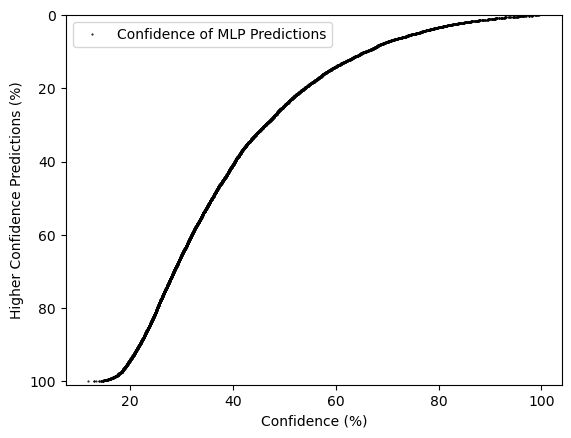

2023-02-08 21:54:07.376997: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./MLP/assets


In [14]:
print(model_profiler(MLP, 32, use_units=units))
MLP_accuracy = evaluateModel(MLP, x_test=x_test, y_test=y_test, modelName="MLP")
MLP.save('./MLP')

#### Compiling and Fitting LeNet-5

In [15]:
LeNet5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
LeNet5.fit(x=x_train, y=y_train, epochs=10)

2023-02-08 21:55:21.759666: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/10
1563/1563 [==============================] - 19s 9ms/step - loss: 1.8728 - accuracy: 0.3105
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4563 - accuracy: 0.4690
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3297 - accuracy: 0.5214
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.2356 - accuracy: 0.5559
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1806 - accuracy: 0.5777
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1315 - accuracy: 0.5967
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0796 - accuracy: 0.6192
Epoch 8/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0419 - accuracy: 0.6299
Epoch 9/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0181 - accuracy: 0.6394
Epoch 10/10
1563/1563 [==============================] - 10s 6ms/step - loss:

#### Evaluating LeNet5

/home/kolton/anaconda3/envs/honors-thesis/lib/python3.9/site-packages/model_profiler/profiler.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(values).reshape(-1,1),
2023-02-08 21:57:10.578106: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-08 21:57:10.578774: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-08 21:57:10.578813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design computeCapability: 7.5
coreClock: 1.335GHz c

| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.0066  | MFLOPs  |
| GPU Memory Requirement           | 1.3461  | MB      |
| Model Parameters                 | 0.0404  | Million |
| Memory Required by Model Weights | 0.1541  | MB      |
313/313 [==============================] - 2s 5ms/step - loss: 1.0982 - accuracy: 0.6085


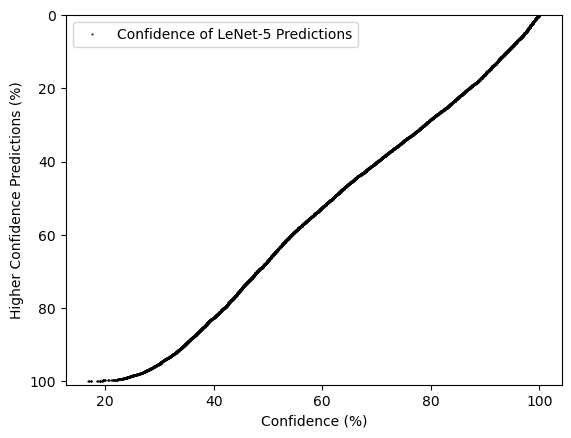

INFO:tensorflow:Assets written to: ./LeNet-5/assets


In [16]:
print(model_profiler(LeNet5, 32, use_units=units))
LeNet5_accuracy = evaluateModel(LeNet5, x_test=x_test, y_test=y_test, modelName="LeNet-5")
LeNet5.save('./LeNet-5')

#### Compiling and Fitting AlexNet

In [17]:
AlexNet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
AlexNet.fit(x=x_train, y=y_train, epochs=10)

2023-02-08 21:59:09.635875: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/10
1563/1563 [==============================] - 29s 13ms/step - loss: 1.7493 - accuracy: 0.3526
Epoch 2/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.2260 - accuracy: 0.5607
Epoch 3/10
1563/1563 [==============================] - 12s 7ms/step - loss: 1.0406 - accuracy: 0.6343
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9367 - accuracy: 0.6725
Epoch 5/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.8408 - accuracy: 0.7053
Epoch 6/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.7882 - accuracy: 0.7197
Epoch 7/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.7139 - accuracy: 0.7497
Epoch 8/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.6631 - accuracy: 0.7659
Epoch 9/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.6022 - accuracy: 0.7855
Epoch 10/10
1563/1563 [==============================] - 12s 8ms/step - 

#### Evaluating AlexNet

/home/kolton/anaconda3/envs/honors-thesis/lib/python3.9/site-packages/model_profiler/profiler.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(values).reshape(-1,1),
2023-02-08 22:01:38.926035: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-08 22:01:38.926321: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-08 22:01:38.926359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design computeCapability: 7.5
coreClock: 1.335GHz c

| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.6667  | MFLOPs  |
| GPU Memory Requirement           | 22.366  | MB      |
| Model Parameters                 | 2.7254  | Million |
| Memory Required by Model Weights | 10.3966 | MB      |
313/313 [==============================] - 2s 6ms/step - loss: 0.9595 - accuracy: 0.7024


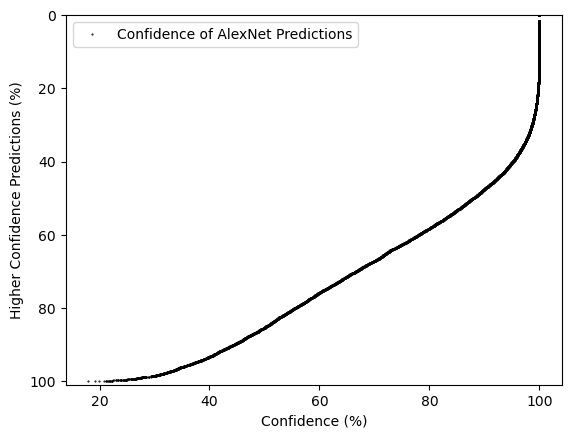

INFO:tensorflow:Assets written to: ./AlexNet/assets


In [18]:
print(model_profiler(AlexNet, 32, use_units=units))
AlexNet_accuracy = evaluateModel(AlexNet, x_test=x_test, y_test=y_test, modelName='AlexNet')
AlexNet.save('./AlexNet')

#### Calculating Pass on Rate

In [19]:
timings = []

for i in tqdm(range(10000)):
	timing = []
	sample = np.array(x_test[i], ndmin=4)

	# MLP logic
	MLP_start = time.time()	
	single_mlp_pred = MLP.predict(sample)
	MLP_stop = time.time()

	timing.append(MLP_stop - MLP_start)

	if single_mlp_pred.max() <= AlexNet_accuracy:
		# LeNet-5 Logic	
		LeNet_start = time.time()
		single_LeNet_pred = LeNet5.predict(sample)
		LeNet_stop = time.time()

		timing.append(LeNet_stop - LeNet_start)

		if single_LeNet_pred.max() <= AlexNet_accuracy:
			# AlexNet Logic
			AlexNet_start = time.time()
			single_AlexNet_pred = AlexNet.predict(sample)
			AlexNet_stop = time.time()

			timing.append(AlexNet_stop - AlexNet_start)

	
	timings.append(timing)

  0%|          | 17/10000 [00:06<1:07:52,  2.45it/s]


KeyboardInterrupt: 

#### Calculate Timing Stats

In [ ]:
MLP_timings, LeNet5_timings, AlexNet_timings = np.array([]), np.array([]), np.array([])

for timing in timings:
	if len(timing) == 1:
		MLP_timings = np.append(MLP_timings, timing)
	elif len(timing) == 2:
		LeNet5_timings = np.append(LeNet5_timings, timing)
	else:
		AlexNet_timings = np.append(AlexNet_timings, timing)

def reject_outliers(data, m=2):
	return data[np.abs(data - np.mean(data)) < m * np.std(data)]

def display_stats(timings, modelName):
	# convert to ms and round to 4 decimal points
	timings = np.around(np.multiply(timings, 1000), 4)

	print("----", modelName, "----")
	print("len: ", len(timings))
	print("mean: ", round(timings.mean(), 2), "ms")
	print("std: ", round(timings.std(), 2), "ms")

	time_chart = plt.hist(timings)
	plt.title(modelName + " Prediction Times")
	plt.xlabel("Prediction Time (ms)")
	plt.ylabel("Number of Predictions")
	plt.show()

MLP_timings, LeNet5_timings, AlexNet_timings = reject_outliers(MLP_timings), reject_outliers(LeNet5_timings), reject_outliers(AlexNet_timings)

display_stats(MLP_timings, "MLP")
display_stats(LeNet5_timings, "LeNet-5")
display_stats(AlexNet_timings, "AlexNet")